# Create fake data to test ability to generate the original distribution

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gamma
from scipy.interpolate import interp1d

from numpy.random import default_rng
rng = default_rng()

In [2]:
# Load the MAGICC data
magic_path = Path("../data/magic_tprime_sh_land.csv")
magicc_df = pd.read_csv(magic_path)
#magicc_df

In [3]:
def date_to_float(date):
    return ((date - np.datetime64("2000-01-01T00")) / np.timedelta64(1,"D")).astype(float)

dates = np.array(magicc_df["date"].to_numpy(), dtype=np.datetime64)
dates_as_floats = date_to_float(dates)
t_primes = magicc_df["ssp245"].to_numpy()
date_as_float_to_tprime_sh_land = interp1d(
    x = dates_as_floats,
    y = t_primes
)

def date_to_tprime_sh_land(date):
    return date_as_float_to_tprime_sh_land(date_to_float(date))

<AxesSubplot:>

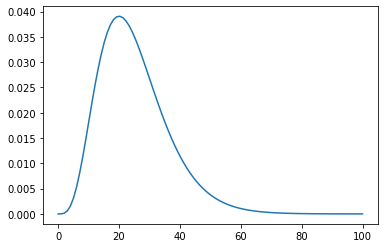

In [4]:
# Let's model precipitation with a gamma
quantiles = np.linspace(0,100, num=100)
shape=5 #0.25
scale=5 #50
ys = gamma.pdf(quantiles, shape, scale=scale)

sns.lineplot(x=quantiles, y=ys)

In [5]:
days_to_simulate = 120 * 365

dates = np.arange(
    start = np.datetime64("1900-01-01"),
    stop = np.datetime64("1900-01-01") + days_to_simulate*np.timedelta64(1,"D"),
    step = np.timedelta64(1,"D")
)

In [6]:
t_primes = date_to_tprime_sh_land(dates)
assert len(t_primes) == len(dates)

In [7]:
# We'll also set the rate of increase in precipitation at a constant 5% per K, not dependent on the quantile
rate = 0.00
def generate_precipitation(t_prime):
    precip = gamma.rvs(shape, scale=scale)
    precip = precip * np.exp(rate*t_prime)
    return precip

In [8]:
precips = np.array([generate_precipitation(t_prime) for t_prime in t_primes])
assert len(precips) == len(dates)

# Add noise
#precips += rng.normal(size=len(precips))
#precips[precips<0] = 0

# Round to 0.1 mm/day
precips = np.round(precips, 1)
#precips = precips[precips!=0]

In [9]:
# Save out data for Leroy's code to use as input
df = pd.DataFrame({
    "date": dates,
    "t_prime": t_primes,
    "precip": precips
})

df.to_csv(f"simulated_precip__gamma_a_{shape}_scale_{scale}_rate_{rate}.csv")
df

,date,t_prime,precip
0,1900-01-01,0.259659,21.9
1,1900-01-02,0.259667,16.0
2,1900-01-03,0.259676,9.3
3,1900-01-04,0.259684,30.1
4,1900-01-05,0.259693,26.7
...,...,...,...
43795,2019-11-28,1.588294,18.0
43796,2019-11-29,1.588370,47.6
43797,2019-11-30,1.588446,51.6
43798,2019-12-01,1.588523,23.0


## Attempt to fit the results using Scipy

In [10]:
# Filter precipitation that's too small to measure
threshold = 0.5
mask = precips > threshold
precips = precips[mask]

# Shift precips, so that Gamma doesn't have to worry about 0 to threshold
precips -= threshold

<AxesSubplot:ylabel='Density'>

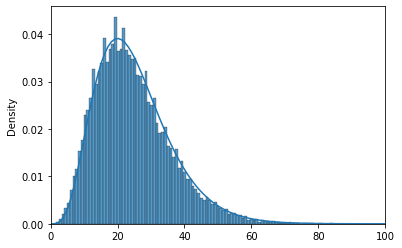

In [11]:
ax=sns.histplot(precips, stat="density")
ax.set_xlim(0,100)

quantiles = np.linspace(0,100, num=100)
ys = gamma.pdf(quantiles, shape, scale=scale)
sns.lineplot(x=quantiles, y=ys)

In [12]:
# Can we get the distribution's parameters from the data?
fit_alpha, fit_loc, fit_beta=gamma.fit(precips, floc=0)
print(fit_alpha, fit_loc, fit_beta)

4.733422833855444 0 5.174291511390691


<AxesSubplot:>

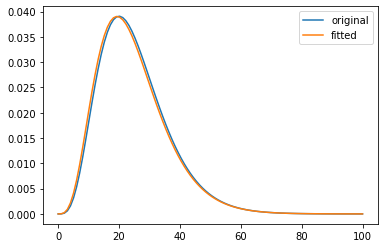

In [13]:
quantiles = np.linspace(0,100, num=100)
ys = gamma.pdf(quantiles, shape, scale=scale)
sns.lineplot(x=quantiles, y=ys, label="original")

ys2 = gamma.pdf(quantiles, fit_alpha, loc=fit_loc, scale=fit_beta)
sns.lineplot(x=quantiles, y=ys2, label="fitted")

## Fit Gamma(5,5) rate 0% with basic parameters Gamma(p1,p2)

In [14]:
from spg.jax_utils import pos_only

In [69]:
p1 = 3.28469618
p1 = pos_only(p1)

In [70]:
p2 = 0.95869868
p2 = pos_only(p2)

In [71]:
data_scale = 11.225783881194642
data_thresh = 0.5

In [72]:
alpha = p1
beta = p2

<AxesSubplot:ylabel='Density'>

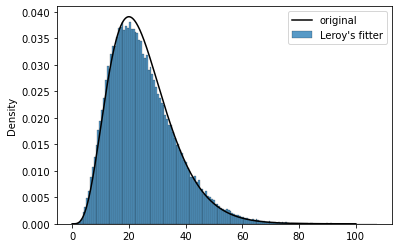

In [19]:
precips = gamma.rvs(alpha, scale=1/beta, size=100000) * data_scale + data_thresh
sns.histplot(precips, stat="density", label="Leroy's fitter")

quantiles = np.linspace(0,100, num=1000)
shape=5
scale=5
ys = gamma.pdf(quantiles, shape, scale=scale)
sns.lineplot(x=quantiles, y=ys, color="black", label="original")


## Fit Gamma(5,5) rate 0% with Gamma(a1 e<sup>rate1 x</sup>, a2 e<sup>rate2 x</sup>) 

In [63]:
a1 = 4#2.54906007
a2 = -1.6094379124341003#=np.log(0.2) #-1.9964807
rate1 = 0#0.58933889
rate2 = 0#-0.25835455

In [64]:
data_scale = 1#11.225783881194642
data_thresh = 0#0.5

In [65]:
t_prime = 0
alpha = a1*np.exp(rate1*t_prime)
beta = a2*np.exp(rate2*t_prime)
alpha = pos_only(alpha)
beta = pos_only(beta)

<AxesSubplot:ylabel='Density'>

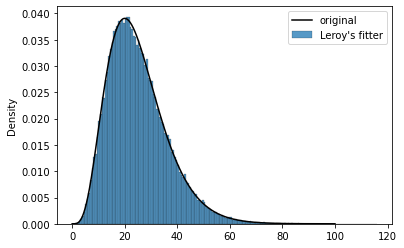

In [66]:
precips = gamma.rvs(alpha, scale=1/beta, size=100000) * data_scale + data_thresh
sns.histplot(precips, stat="density", label="Leroy's fitter")

quantiles = np.linspace(0,100, num=1000)
shape=5
scale=5
ys = gamma.pdf(quantiles, shape, scale=scale)
sns.lineplot(x=quantiles, y=ys, color="black", label="original")


/tmp/ipykernel_2532414/2565292549.py:20: RuntimeWarning: invalid value encountered in true_divide
  rates = np.log(precips_at_1/precips_at_0)


Text(0, 0.5, 'Rate (% per K)')

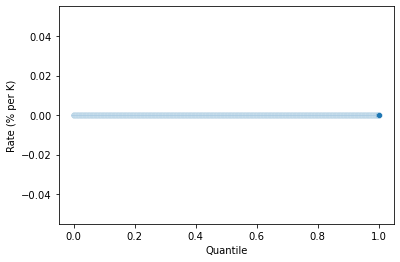

In [67]:
# Calculate the rate per quantile
quantiles = np.linspace(0,1, num=1000)

t_prime = 0
alpha = a1*np.exp(rate1*t_prime)
beta = a2*np.exp(rate2*t_prime)
alpha = pos_only(alpha)
beta = pos_only(beta)

precips_at_0 = gamma.ppf(quantiles, alpha, scale=1/beta) * data_scale + data_thresh

t_prime = 1
alpha = a1*np.exp(rate1*t_prime)
beta = a2*np.exp(rate2*t_prime)
alpha = pos_only(alpha)
beta = pos_only(beta)

precips_at_1 = gamma.ppf(quantiles, alpha, scale=1/beta) * data_scale + data_thresh

rates = np.log(precips_at_1/precips_at_0)
ax = sns.scatterplot(
    x=quantiles,
    y=rates*100
)
ax.set_xlabel("Quantile")
ax.set_ylabel("Rate (% per K)")

## How's t_prime distributed in the fake data?

In [25]:
file_path = Path("../data/simulated_precip__gamma_a_5_scale_5_rate_0.0.csv")
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,date,t_prime,precip
0,0,1900-01-01,0.259659,22.2
1,1,1900-01-02,0.259667,22.2
2,2,1900-01-03,0.259676,19.3
3,3,1900-01-04,0.259684,31.3
4,4,1900-01-05,0.259693,17.2


<AxesSubplot:xlabel='t_prime', ylabel='Count'>

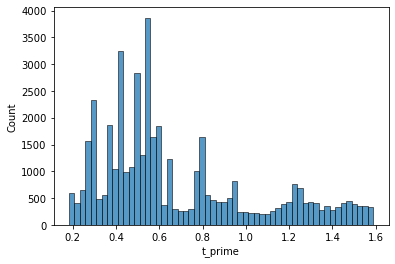

In [26]:
sns.histplot(df["t_prime"])

In [27]:
np.mean(df["t_prime"])

0.6803003623049727

## Are the TensorFlow Gamma and Scipy Gamma interchangeable?

They are if you inverse the scale (beta) parameter.

In [28]:
import os

In [29]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [30]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [31]:
dist = tfd.Gamma(5,1/5)

2022-04-04 16:30:50.262605: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-04 16:30:51.458965: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-04-04 16:30:51.459067: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 510.47.3 does not match DSO version 510.54.0 -- cannot find working devices in this configuration


<AxesSubplot:>

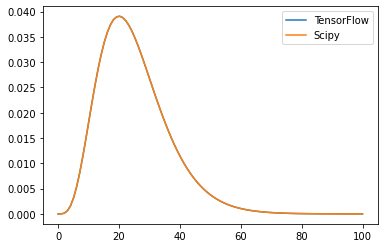

In [32]:
quantiles = np.linspace(0,100, num=100)
result = dist.prob(quantiles)
ys = result.numpy()

sns.lineplot(x=quantiles, y=ys, label="TensorFlow")

ys2 = gamma.pdf(quantiles, shape, scale=scale)
sns.lineplot(x=quantiles, y=ys2, label="Scipy")


<AxesSubplot:ylabel='Count'>

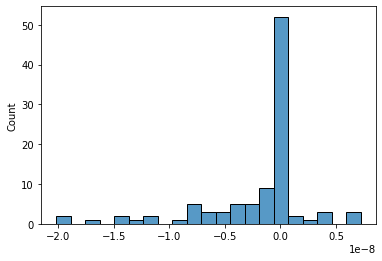

In [33]:
sns.histplot(ys-ys2)